In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
import tokenizers.pre_tokenizers as pre_tokenizers
import tokenizers.processors as processors
import tokenizers.decoders as decoders
from tokenizers.trainers import BpeTrainer

from torchinfo import summary

torch.manual_seed(1357)

In [144]:
with open('/kaggle/input/shakespere/shakespere.txt','r',encoding='utf-8') as f:
    data = f.read()

In [145]:
data[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [146]:
tokenizer_path = Path('./tokenizer/')
tokenizer_path.mkdir(exist_ok=True)

tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
trainer = BpeTrainer(special_tokens=['<|endoftext|>'], min_frequency=2)

tokenizer.train(['/kaggle/input/shakespere/shakespere.txt'],trainer)
tokenizer.save(str(tokenizer_path / 'shakespeare.json'))

In [147]:
@dataclass
class Config:
    
    block_size = 256 # context-length
    batch_size = 64 # mini-batch size
    
    vocab_size = tokenizer.get_vocab_size()
    
    train_size = 0.9 
    
    n_embed = 384
    n_heads = 6
    head_size = n_embed // n_heads # computes to 384/6=64
    
    n_layers = 12
    
    train_iters = 5000 # no. of batches to train on
    val_iters = 500 # no. of batches to validate on every eval_intervals
    
    eval_interval = 1000 # validate after every eval_interval iterations while training
    
    lr = 1e-5
    
    attn_dropout = 0.2
    block_dropout = 0.2
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device, Config.vocab_size

('cuda', 12523)

In [148]:
class ShakespeareDataset:
    def __init__(self, Config, is_test=False) -> None:
        self.file_path = Path('/kaggle/input/shakespere/shakespere.txt')
        self.tokenizer_path = Path('/kaggle/working/tokenizer/shakespeare.json')
        with open(self.file_path,'r',encoding='utf-8') as f:
            self.data = f.read()
        self.tokenizer = Tokenizer.from_file(str(self.tokenizer_path))
        
        self.full_data = torch.tensor(self.tokenizer.encode(self.data).ids, dtype=torch.long)
        
        self.is_test = is_test
        if self.is_test:
            self.data = self.full_data[int(Config.train_size*len(self.full_data)):]
        else:
            self.data = self.full_data[:int(Config.train_size*len(self.full_data))]

        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.get_vocab_size()

    def __next__(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x,y

In [149]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

In [150]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x


In [151]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.GELU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)


In [152]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ff = FeedForward(Config)
        self.ln2 = nn.LayerNorm(Config.n_embed)
#         self.ff = FeedForward(Config)
#         self.ln1 = nn.LayerNorm(Config.n_embed)
#         self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
#         x = x + self.attn(self.ln1(x))
#         x = x + self.ff(self.ln2(x))
        # Attention sublayer with residual connection
        attn_out = self.attn(x)
        x = x + attn_out
        # Layer normalization
        x = self.ln1(x)
        # Feedforward sublayer with residual connection
        ff_out = self.ff(x)
        x = x + ff_out
        # Layer normalization
        x = self.ln2(x)
        return x
        
        


In [153]:
class ShakespeareGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

In [154]:
train_ds = ShakespeareDataset(Config)
val_ds = ShakespeareDataset(Config,is_test=True)

In [155]:
lm = ShakespeareGPT(Config)
lm = lm.to(device=Config.device)

In [156]:
summary(lm,input_size=(Config.batch_size, Config.block_size),dtypes=[torch.long],depth=5,)


Layer (type:depth-idx)                             Output Shape              Param #
ShakespeareGPT                                     [64, 256, 12523]          --
├─Embedding: 1-1                                   [64, 256, 384]            4,808,832
├─Embedding: 1-2                                   [256, 384]                98,304
├─Sequential: 1-3                                  [64, 256, 384]            --
│    └─TransformerBlock: 2-1                       [64, 256, 384]            --
│    │    └─MultiHeadAttention: 3-1                [64, 256, 384]            --
│    │    │    └─ModuleList: 4-45                  --                        (recursive)
│    │    │    │    └─AttentionHead: 5-1           [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-2           [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-3           [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-4           [64, 256, 64]             73,728

In [157]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)


In [158]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

In [159]:
@torch.no_grad()
def valid_N_iters():
    val_step_losses = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = next(val_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())
        
        del inputs, targets, loss, logits
    
    val_loss = torch.tensor(val_step_losses).mean()
    print(f'val loss: {val_loss}')
    return val_loss

In [160]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    val_losses = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = next(train_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())
        
        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"\n{'-'*50}\nbatch {batch} train step loss: {loss.item()}")
            print(f"train loss so far: {torch.tensor(train_step_losses).mean()}\n{'-'*50}\n")
            
        if batch%Config.eval_interval==0 or batch==Config.train_iters-1:
            lm.eval()
            val_loss = valid_N_iters()
            lm.train()
            val_losses.append(val_loss.item())
            
            del val_loss
            
        del inputs, targets, loss, logits
        
    return train_step_losses, val_losses


In [161]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'shakespeareGPT'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'shakespeareGPT.pth'
    torch.save(state_dict, model_path)


In [162]:
def train_lm():
    train_step_losses,val_losses = train_N_iters()
    save_lm()
    return train_step_losses,val_losses

In [163]:
tsl,vl=train_lm()


  0%|          | 0/5000 [00:00<?, ?it/s]


--------------------------------------------------
batch 0 train step loss: 9.546625137329102
train loss so far: 9.546625137329102
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 9.525571823120117

--------------------------------------------------
batch 500 train step loss: 8.395170211791992
train loss so far: 8.955549240112305
--------------------------------------------------


--------------------------------------------------
batch 1000 train step loss: 7.334833145141602
train loss so far: 8.391990661621094
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 7.2911834716796875

--------------------------------------------------
batch 1500 train step loss: 6.6329026222229
train loss so far: 7.908322334289551
--------------------------------------------------


--------------------------------------------------
batch 2000 train step loss: 6.272305488586426
train loss so far: 7.5371856689453125
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 6.276923656463623

--------------------------------------------------
batch 2500 train step loss: 6.226741790771484
train loss so far: 7.279222011566162
--------------------------------------------------


--------------------------------------------------
batch 3000 train step loss: 6.167212963104248
train loss so far: 7.099625587463379
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 6.230064868927002

--------------------------------------------------
batch 3500 train step loss: 6.141937732696533
train loss so far: 6.967227935791016
--------------------------------------------------


--------------------------------------------------
batch 4000 train step loss: 6.162447452545166
train loss so far: 6.865241050720215
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 6.218489170074463

--------------------------------------------------
batch 4500 train step loss: 6.191037654876709
train loss so far: 6.784393310546875
--------------------------------------------------


--------------------------------------------------
batch 4999 train step loss: 6.10130500793457
train loss so far: 6.718660354614258
--------------------------------------------------



  0%|          | 0/500 [00:00<?, ?it/s]

val loss: 6.2060723304748535


In [164]:
tsl_mean = torch.tensor(tsl).mean()
print('Train Loss:',tsl_mean.item())

Train Loss: 6.718660354614258


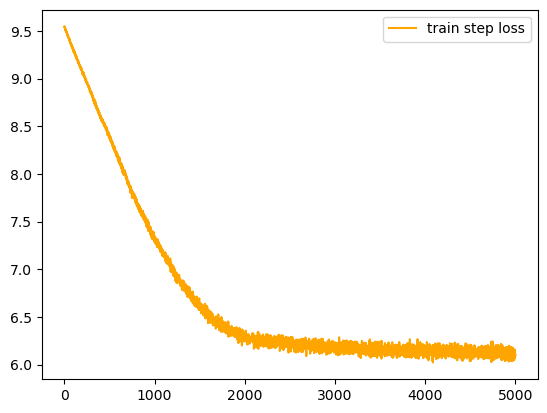

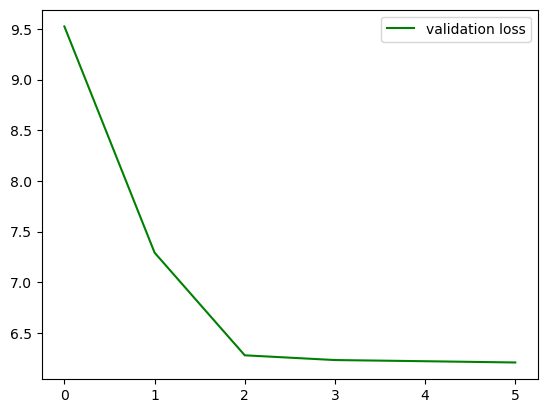

In [165]:
plt.plot(tsl,label='train step loss',color='orange')
plt.legend()
plt.show()
plt.plot(vl,label='validation loss',color='green')
plt.legend()
plt.show()

In [166]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+61, # initial context 61 (i believe its \n)
    total=length
)
    generated = tokenizer.decode(generated[0].cpu().numpy())
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)
x,ingBENVOLIO keep, to, penitence a
 a; possessINC?His married
 on ageAnd:; tops good:And Hereford:
 Will believe confound more matter of'sSpeak, cannot poor Keeper, defence my hath to
 B
 my: henceHold field tellMENENIUS. us you who't long the he the hath villain.
 because variable back affection thy schoolmaster my play
 are breasts
 say Captain
 Edwardld womb withGodGREY crest!? must
, do of princes


generated (300 tokens)
x
 now graceless
 be masterFRIAR where dom return,
 a commission France; colour Bohemia
 III soil their bolder
 acquainted them
: a int was know bitter
 of majestyOf his stay straightAs
 and hither lives: there
 the curds,, loved. he to day, thouBut on on down far: not of nobleness Camillo and
! hereATH for take
Besidesacheth must corse cousins. a
 Fourth my
 with; intents be tell sp still
 I of with soof he, disl fears? exhales Keeper soncont them whether
s I speak yourtirts
, what do more'And to in itself all the asra: made woman,' ofek?,